In [1]:
# imports
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import joblib
from models.mlp import build_mlp
from utils.data_loader import load_for_mlp

In [ ]:
# Specify datasets that should be used for training
datasets=["exp1","exp5","exp6","exp7"]

# Specify index of target variable
# 0 for fco2
# 1 for fco2_pre 
# 2 for co2flux 
# 3 for co2flux_pre
target_index = 3 

# Specify amount of datapoints that should be randomly selected. If you want to select all datapoints, set to -1.
# This amount will be divided into training, validation and test set (80%, 10%, 10%).
N = 60_000_000 

# Specify model parameters
n_epochs = 100
batch_size = 1024
lr = 0.0002 
baseLayerSize = 512
dropoutRate = 0.05 
l2_reg = 0

In [ ]:
# load and scale data
features, targets = load_for_mlp(datasets=datasets, target_index=target_index)
    
mask = features[:, 10] == 1
features = np.delete(features, [10], axis=1)
features = features[mask]
targets = targets[mask]

filtered_features = features
filtered_targets = targets

if N != -1 and N < len(features):
    rng = np.random.default_rng(seed=42)
    idx = rng.choice(len(filtered_features), size=N, replace=False)
    filtered_features = filtered_features[idx]
    filtered_targets = filtered_targets[idx]

X_train = filtered_features[:int(0.8 * len(filtered_features))]
Y_train = filtered_targets[:int(0.8 * len(filtered_targets))]
X_val = filtered_features[int(0.8 * len(filtered_features)):int(0.9 * len(filtered_features))]
Y_val = filtered_targets[int(0.8 * len(filtered_targets)):int(0.9 * len(filtered_targets))]
X_test = filtered_features[int(0.9 * len(filtered_features)):]
Y_test = filtered_targets[int(0.9 * len(filtered_targets)):]

feature_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
folder_path = "../../outputs/mlp/" + timestamp
os.makedirs(folder_path, exist_ok=True)

joblib.dump(feature_scaler, folder_path + '/scaler.pkl')

['../../outputs/mlp/2025-10-01_18-12/scaler.pkl']

In [4]:
# build model
model = build_mlp(base_layer_size=baseLayerSize, dropout_rate=dropoutRate, l2_reg=l2_reg, lr=lr)
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )

In [5]:
# start training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
 
history = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,             
    batch_size=batch_size,          
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.5549 - mae: 0.5067 - val_loss: 0.6158 - val_mae: 0.5197 - learning_rate: 2.0000e-04
Epoch 2/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.3297 - mae: 0.3944 - val_loss: 0.4137 - val_mae: 0.4239 - learning_rate: 2.0000e-04
Epoch 3/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.2688 - mae: 0.3565 - val_loss: 0.3810 - val_mae: 0.3995 - learning_rate: 2.0000e-04
Epoch 4/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.2318 - mae: 0.3314 - val_loss: 0.3763 - val_mae: 0.3946 - learning_rate: 2.0000e-04
Epoch 5/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 0.2072 - mae: 0.3126 - val_loss: 0.3879 - val_mae: 0.4077 - learning_rate: 2.0000e-04


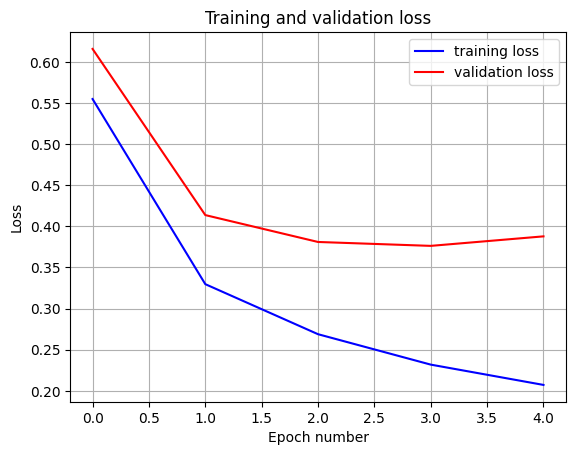

In [6]:
# save model
model.save(folder_path + "/model.keras")

#  save training history
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

path = folder_path + '/training_history.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [7]:
test_pred = model.predict(X_test)

mse = mean_squared_error(test_pred, Y_test)
mae = mean_absolute_error(test_pred, Y_test)
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Squared Error: 0.378
Mean Absolute Error: 0.369


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


22545/22545 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


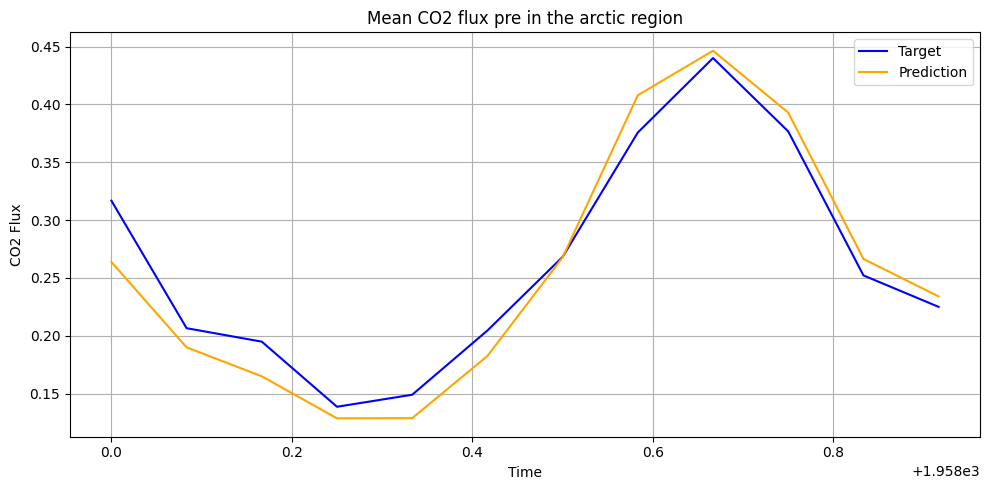

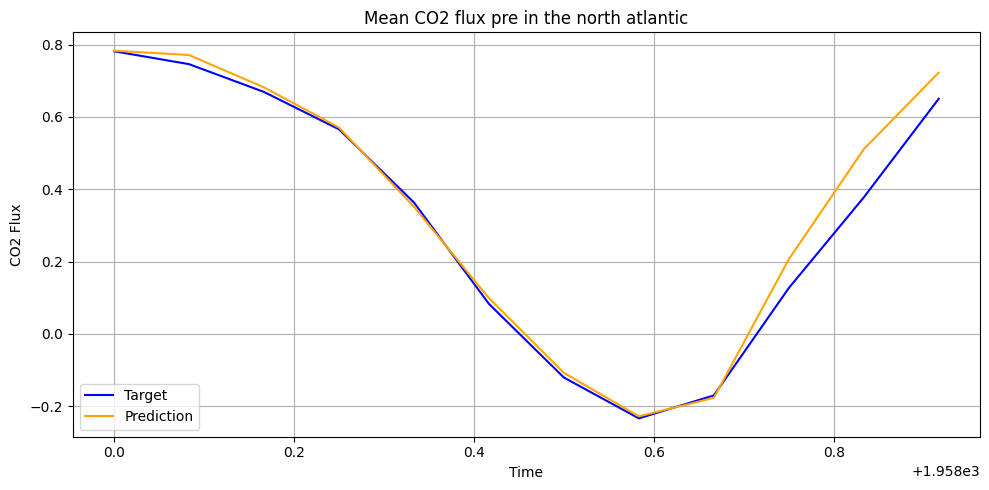

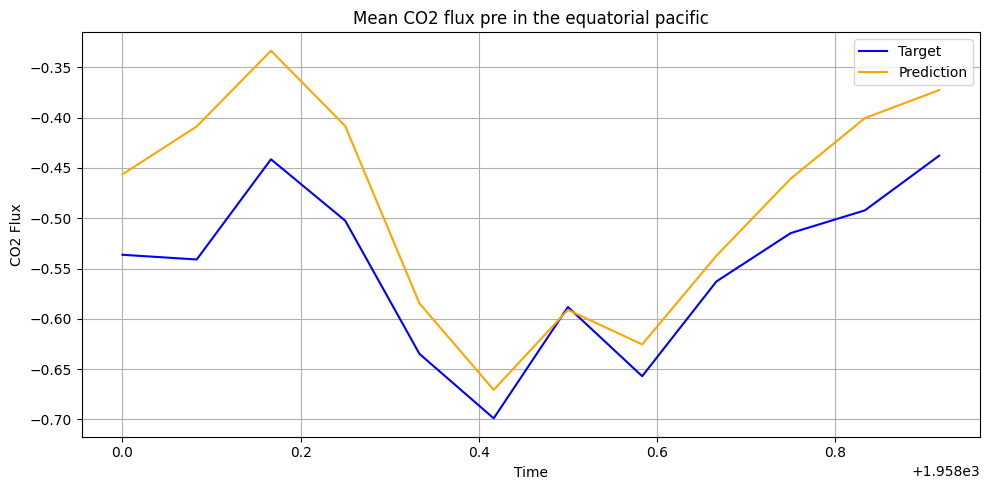

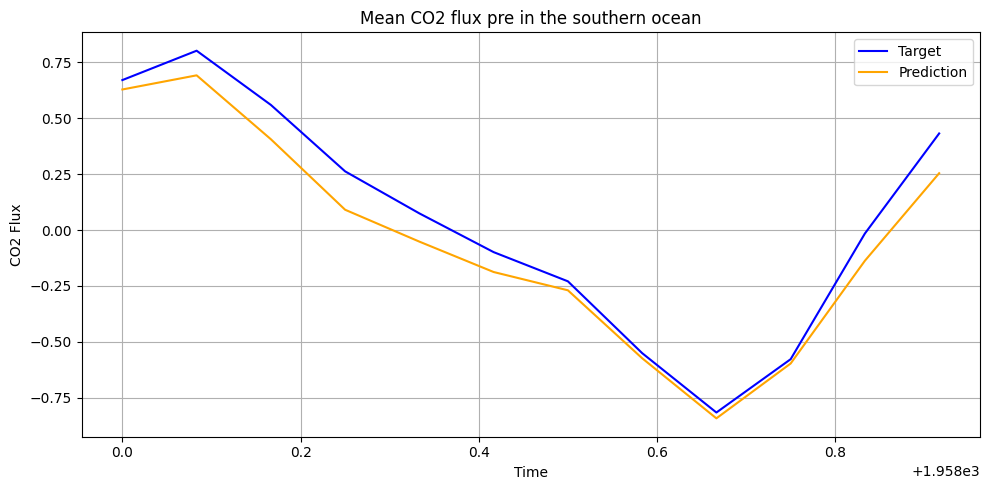

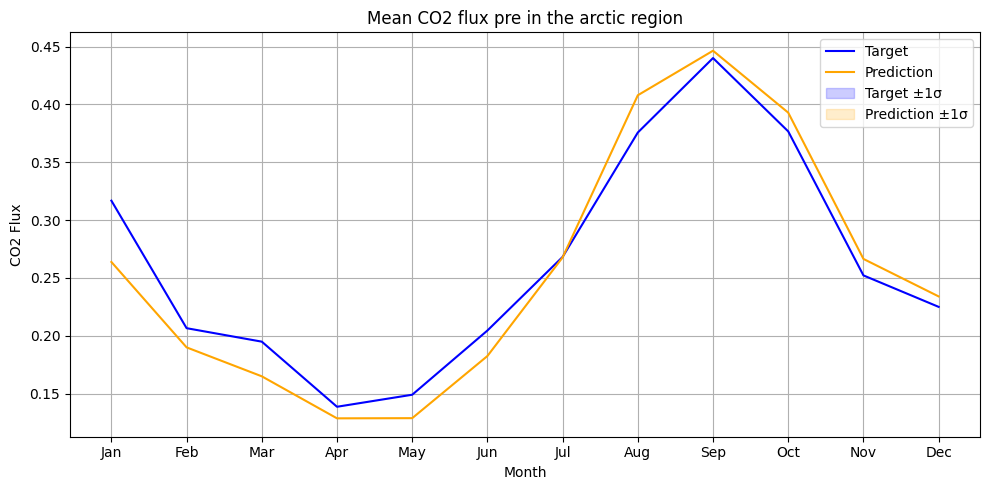

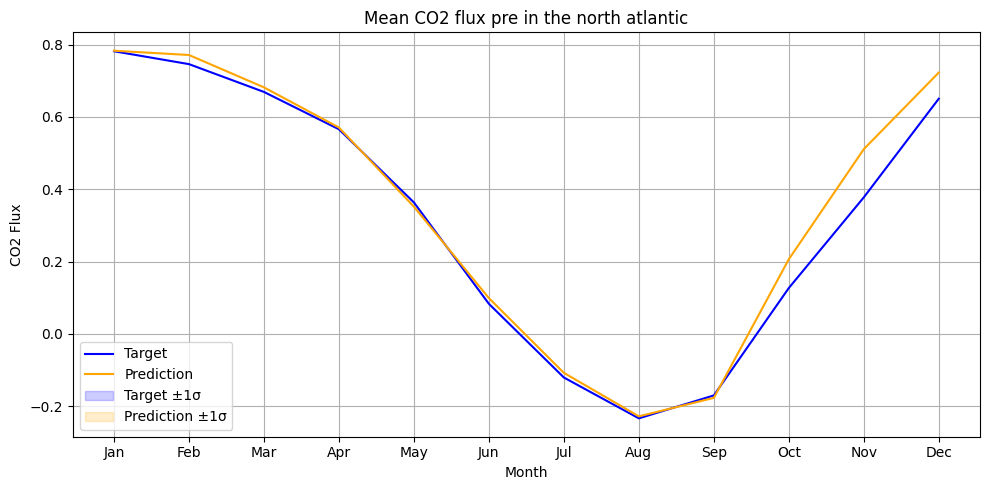

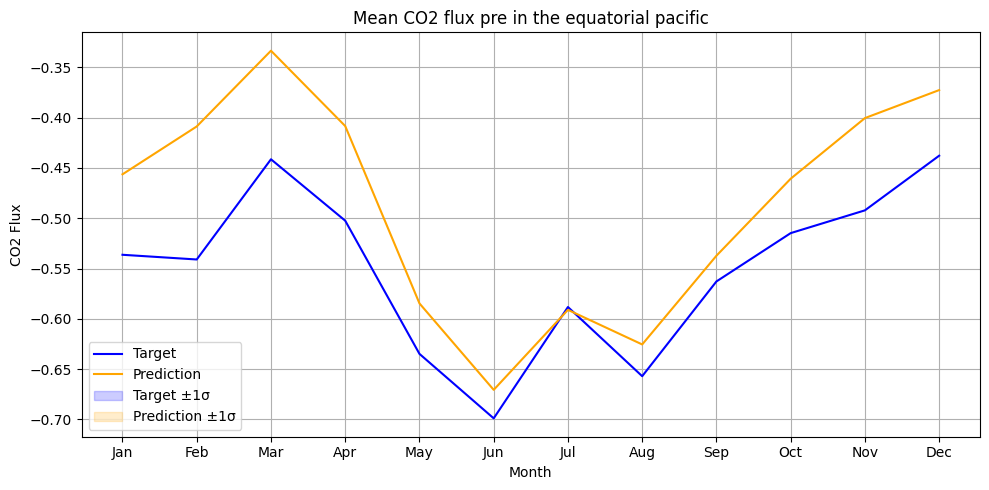

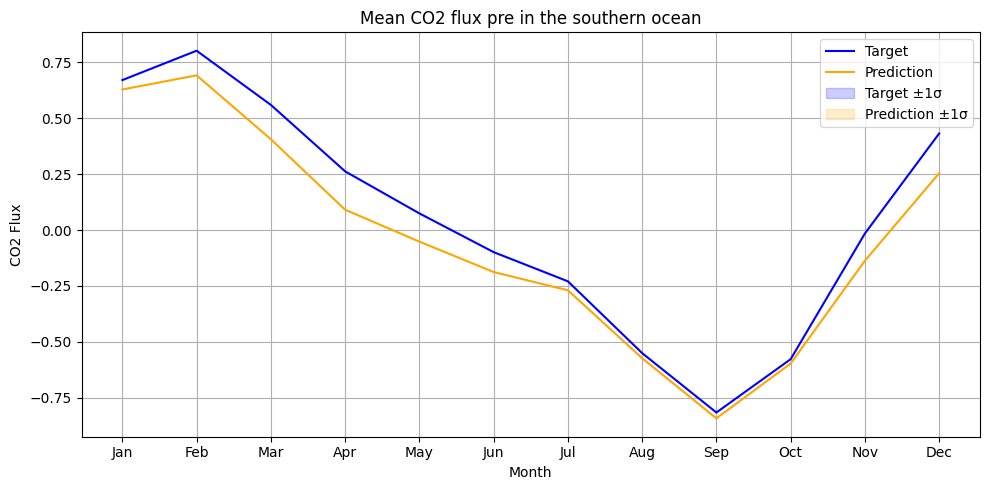

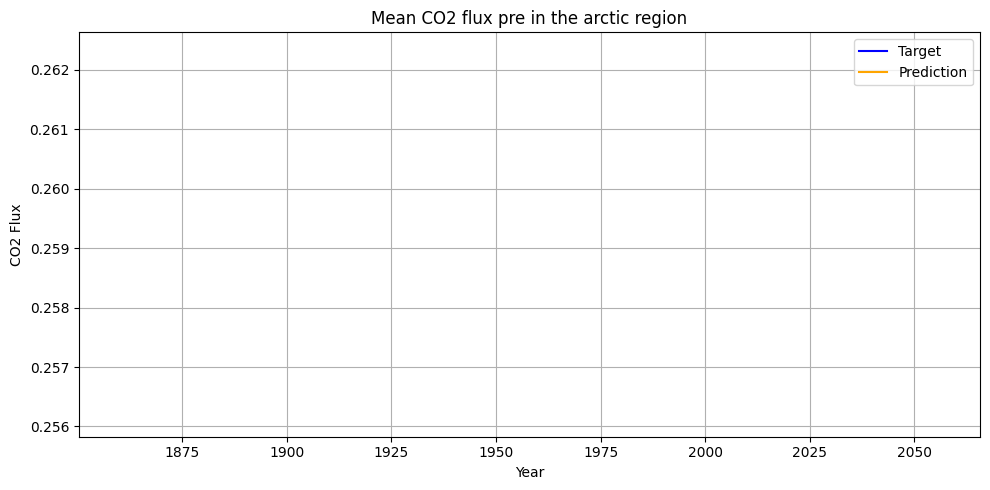

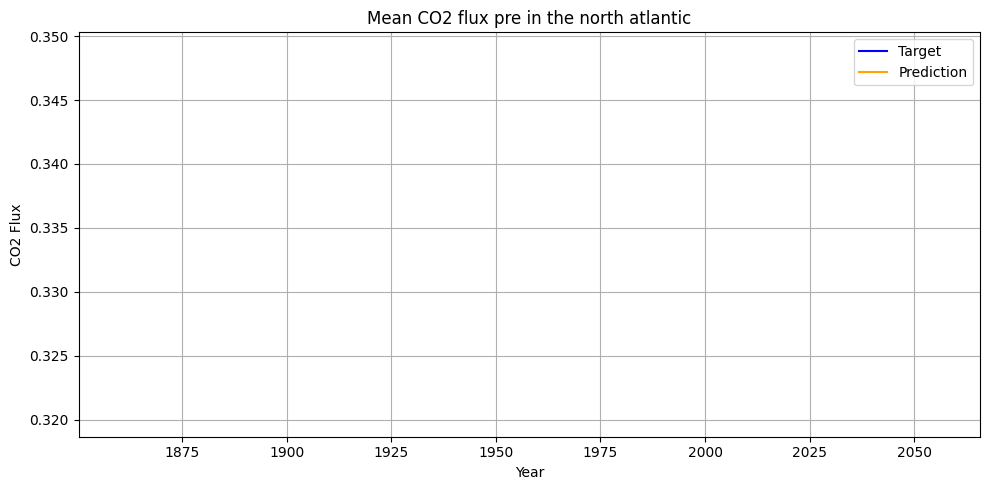

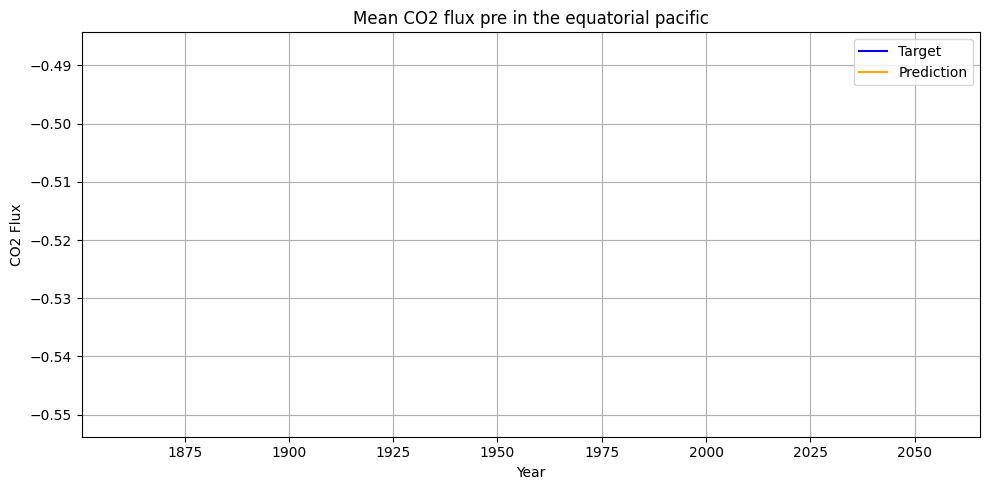

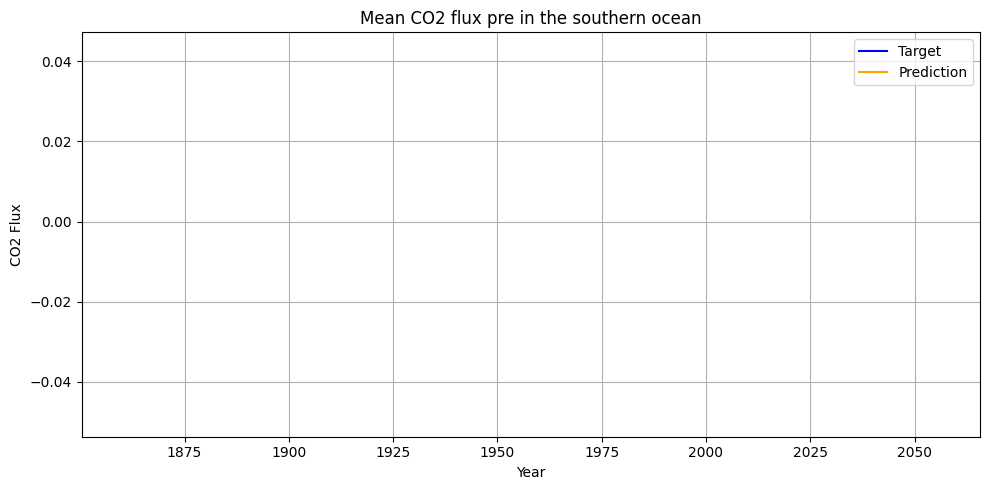

In [8]:
from utils.model_analysis import complete_model_analysis_mlp

for dataset_id in datasets:
    complete_model_analysis_mlp(folder_path, dataset_id, target_index=target_index)